In [59]:
from torch.utils.data import Dataset, DataLoader

import cv2
import glob
import numpy
import random
from pandas.core.common import flatten
from PIL import Image

%matplotlib inline

import matplotlib.pyplot as plt
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [60]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [61]:
####################################################
#       Create Train, Valid and Test sets
####################################################
train_data_path = 'fruit_dataset/train'  ##yang ni letak train (gambar) sendiri
test_data_path = 'fruit_dataset/validation'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('\\')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nTest size: {}".format(len(train_image_paths), len(test_image_paths)))

train_image_path example:  fruit_dataset/train\watermelon\225650f1f8d37b26b6b284bb59ef01f7dc0c5562.jpg
class example:  durian
Train size: 521
Test size: 323


In [62]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
class_to_idx

{'durian': 0, 'pumpkin': 1, 'tomato': 2, 'watermelon': 3}

In [63]:
from torch.utils.data import Dataset

#######################################################
#               Define Dataset Class
#######################################################

class fruitDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
#         image = cv2.imread(image_filepath)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.open(image_filepath) # if using torchvision transforms
        
        label = image_filepath.split('\\')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image) # if using torchvision transforms
        
        return image, label

In [64]:
#######################################################
#                  Create Dataset
#######################################################

train_dataset = fruitDataset(train_image_paths,image_transforms['train'])
test_dataset = fruitDataset(test_image_paths,image_transforms['test'])

In [65]:
train_dataset.transform

Compose(
    RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [66]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 224, 224])
The label for 50th image in train dataset:  3


In [67]:
from torch.utils.data import DataLoader

In [68]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=train_dataset, # use custom created train Dataset
                                     batch_size=4, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=test_dataset, # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

521
323


In [69]:
#batch of image tensor
next(iter(trainloader))[0].shape

torch.Size([4, 3, 224, 224])

In [70]:
#batch of the corresponding labels
next(iter(trainloader))[1].shape

torch.Size([4])

In [71]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 10)

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

C:\Users\anuar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\anuar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\anuar/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:14<0

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [72]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [73]:
# 4. Train the model for 10 epochs
 
num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.8912, Accuracy: 40.6910%, 
		Validation : Loss : 2.3205, Accuracy: 18.8854%, Time: 56.5281s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.3365, Accuracy: 53.1670%, 
		Validation : Loss : 2.2356, Accuracy: 23.8390%, Time: 49.4450s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.1693, Accuracy: 57.9655%, 
		Validation : Loss : 2.1801, Accuracy: 26.0062%, Time: 48.1388s
Epoch: 4/10
Epoch : 003, Training: Loss: 1.0545, Accuracy: 65.2591%, 
		Validation : Loss : 2.0378, Accuracy: 31.5789%, Time: 47.7652s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.9885, Accuracy: 64.8752%, 
		Validation : Loss : 1.8417, Accuracy: 35.2941%, Time: 48.6506s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.9281, Accuracy: 65.2591%, 
		Validation : Loss : 1.8935, Accuracy: 33.4365%, Time: 48.4887s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.8997, Accuracy: 66.7946%, 
		Validation : Loss : 1.7786, Accuracy: 37.4613%, Time: 49.5089s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.8756, Accura

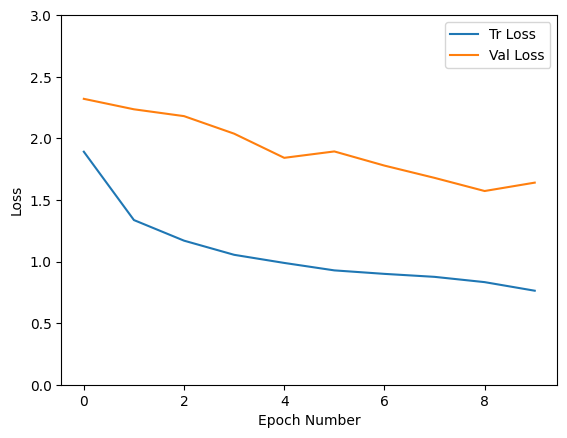

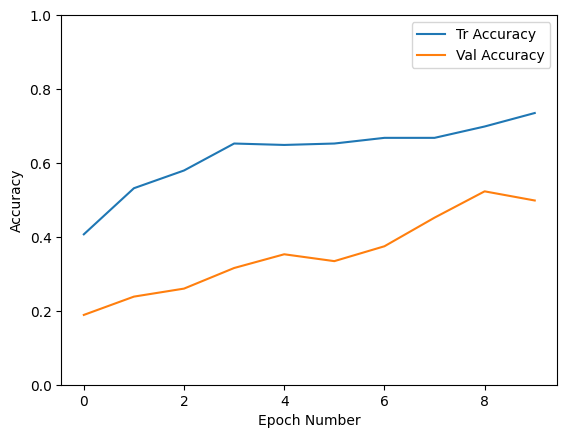

In [74]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()